In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption
import copy
from IPython.display import display

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/pyplot.py:879: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


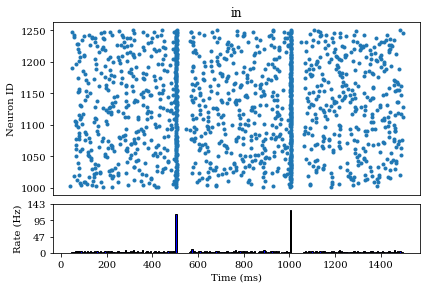

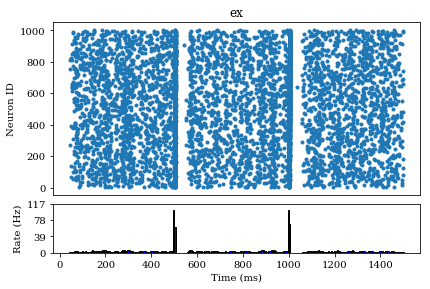

In [3]:
from params_1 import parameters
sim = Simulator(parameters, fname='voltage_dist_AI', data_path='results', 
                stim_N=2, stim_period=500, stim_dist=None)
sim.simulate(state=False, save=False, raster=True)

In [4]:
data = sim.data

In [5]:
def norm(a):
    a = np.array(a)
    b = a - a.min()
    return b / b.max()

In [6]:
stim_times = sim.data['epoch']['times']
spiketrains = {}
neuron_ids = {}
for pop in ['ex', 'in']:
    senders = sim.data['spiketrains'][pop]['senders']
    if pop == 'ex':
        sender_ids = data['stim_nodes'][pop]
    else:
        sender_ids = np.unique(senders)[:250]
    times = sim.data['spiketrains'][pop]['times']
    spiketrains[pop] = [t for sender in sender_ids for t in times[sender==senders]]
    neuron_ids[pop] = [s for sender in sender_ids for s in [sender] * sum(sender==senders)]

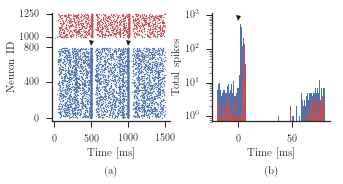

In [9]:
set_style('article', sns_style='ticks')
size = 1 # 10 # notebook
arrow_size = 5 # 25 # notebook
color = {'ex': 'b', 'in': 'r'}
width = 3
xmin = -20
xmax = 80

fig = plt.figure()
gs0 = GridSpec(1, 2, wspace=.35)

gs00 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], **{'height_ratios': [1, 800/250], 'hspace': 0.01})
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[1, 0])

ax1.scatter(spiketrains['in'], neuron_ids['in'], color='r', s=size)
despine(xticks=False, bottom=True, ax=ax1)

ax2.scatter(spiketrains['ex'], neuron_ids['ex'], s=size)
despine(ax=ax2)
ax2.set_yticks([0, 400, 800])
ax2.set_xticks([0, 500, 1000, 1500])

y = 850
ax2.plot([500, 1000], [y, y], ls='none', marker='v', color='k', markersize=arrow_size)

ax2.set_xlabel('Time [ms]')
fig.text(0.0, 0.5, 'Neuron ID', va='center', rotation='vertical')


gs01 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax = fig.add_subplot(gs01[0, 0])

for pop in ['ex', 'in']:
    spikes = []
    for t in [500, 1000]:
        sptr = np.array(spiketrains[pop]) - t
        sptr = sptr[(sptr > xmin) & (sptr < xmax)]
        spikes.extend(sptr.tolist())
    
#     bins = np.arange(xmin, xmax + width, width)
#     hist, bins = np.histogram(spikes, bins=bins)
#     ax.bar(bins[1:], hist, color=color[pop], width=-width, align='edge')
    ax.hist(spikes, color=color[pop], bins=100, log=True)

ax.plot(0, 850, ls='none', marker='v', color='k', markersize=arrow_size)
despine()
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Total spikes')
add_caption([ax2, ax], start='a')
savefig(fig, 'network-raster')